# Bayesian Inference

So far we've focused on _frequentist_ inference techniques: asymptotically normal approximations, Wald confidence intervals, etc. 
Today we'll discuss an alternative approach based on Bayesian inference. 
While the two approaches are philosophically quite different, we'll see that the statistical inferences they lead to can be quite similar in many cases.

## Setup

In [87]:
import matplotlib.pyplot as plt
import torch

from sklearn.linear_model import LogisticRegression
from torch.autograd.functional import hessian
from torch.distributions import Bernoulli, Beta, Binomial, MultivariateNormal, Normal
from tqdm.auto import trange


## Introduction
It is tempting to interpret the confidence interval as saying that $\theta$ is in a confidence interval with probability $1-\alpha$ given the observed data, but **that is not justified!** In the setting above, the parameter $\theta$ is **not** a random variable. This fallacy is a classic misinterpretation of frequentist confidence intervals. 

To make such a claim, we need to adopt a Bayesian perspective and reason about the _posterior_ distribution of the parameters, $\theta$, given the data, $x$. To obtain a posterior, we first need to specify a _prior_ distribution on parameters, $p(\theta)$. Given a prior and likelihood, the posterior follows from Bayes' rule,
\begin{align*}
p(\theta \mid x) &= \frac{p(x \mid \theta) \, p(\theta)}{p(x)},
\end{align*}
where 
- $p(\theta \mid x)$ is the **posterior**,
- $p(x \mid \theta)$ is the **likelihood**,
- $p(\theta)$ is the **prior**, and
- $p(x) = \int p(x \mid \theta) \, p(\theta) \dif \theta$ is the **marginal likelihood**. 

Once we have the posterior distribution, then we're really in business.  


## What do we want from the Posterior?
Often, we are particularly interested in **posterior expectations**, like:
- $\E_{p(\theta | x)}[\theta]$, the posterior mean,
- $\E_{p(\theta | x)}[\bbI[\theta \in \cA]]$, the probability of the parameters being in set $\cA$,
- $\E_{p(\theta | x)}[p(x' \mid \theta)]$, the posterior predictive density of new data $x'$.

All of these can be written as $\E_{p(\theta | x)}[f(\theta)]$ for some function $f$.

For point estimation, we may choose the mode, $\hat{\theta}_{\mathsf{MAP}} = \arg \max p(\theta \mid x)$  a.k.a., the **_maximum a posteriori_ (MAP)** estimate. 

We can also obtain an analogue of frequentist confidence intervals by summarizing the posterior in terms of a **Bayesian credible interval**: a set of parameters that captures $1-\alpha$ probability under the posterior. There are infinitely many such sets, but a common choice for scalar parameters is the interval ranging from the $\alpha/2$ to the $1-\alpha/2$ quantiles of the posterior distribution. 


## Conjugate Priors

The posterior distribution depends on the choice of prior. Indeed, the subjective choice of prior distributions is the source of much of the criticism of Bayesian approaches. In cases where we truly know nothing about the parameter _a priori_, we can often specify "weak" or "uninformative" prior distributions. Under such assumptions, we'll find that Bayesian and frequentist approaches can yield similar estimates, with the advantage that the Bayesian credible interval admits the intuitive interpretation as a set where $\theta$ is most probable. 

When it comes to choosing a prior distribution, one desiderata is computational tractability. The hard part of Bayesian inference is typically integration: to normalize the posterior we need to compute the marginal likelihood, which is an integral over the parameter space; to compute posterior expectations, we need to do the same. **Conjugate priors** are distributions on $\theta$ that often render these integrals tractable.



### Example: Bernoulli Likelihood with a Beta Prior

The beta distribution is a conjugate prior for a Bernoulli likelihood,
\begin{align*}
\theta &\sim \mathrm{Beta}(\alpha, \beta)
\end{align*}
with support on $\theta \in [0,1]$. Its probability density function (pdf) is,
\begin{align*}
\mathrm{Beta}(\theta; \alpha, \beta) &= \frac{1}{\mathrm{B}(\alpha, \beta)} \theta^{\alpha - 1} (1 - \theta)^{\beta - 1},
\end{align*}
where $\mathrm{B}(\alpha, \beta)$ is the [beta function](https://en.wikipedia.org/wiki/Beta_function) and the hyperparameters $\alpha, \beta \in \reals_+$ determine the shape of the prior. When $\alpha = \beta = 1$, the prior reduces to a uniform distribution on $[0,1]$.


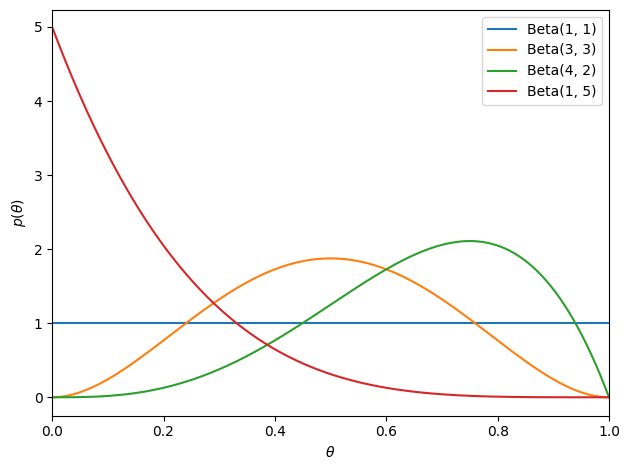

In [15]:
# Plot the beta density

thetas = torch.linspace(0, 1, 1000)
plt.plot(thetas, Beta(1, 1).log_prob(thetas).exp(), label=r'Beta(1, 1)')
plt.plot(thetas, Beta(3, 3).log_prob(thetas).exp(), label=r'Beta(3, 3)')
plt.plot(thetas, Beta(4, 2).log_prob(thetas).exp(), label=r'Beta(4, 2)')
plt.plot(thetas, Beta(1, 5).log_prob(thetas).exp(), label=r'Beta(1, 5)')
plt.xlim(0, 1)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend()
plt.tight_layout()


Under the beta prior, the posterior distribution over $\theta$ is,
\begin{align*}
p(\theta \mid \{x_i\}_{i=1}^n) 
&\propto \mathrm{Beta}(\theta; \alpha, \beta) \prod_{i=1}^n \mathrm{Bern}(x_i \mid \theta) \\
&\propto \theta^{\alpha - 1} (1 - \theta)^{\beta - 1} \prod_{i=1}^n \theta^{x_i} (1 - \theta)^{1 - x_i} \\
&= \theta^{x + \alpha - 1} (1- \theta)^{n - x + \beta - 1} \\
&\propto \mathrm{Beta}(\theta; \alpha', \beta')
\end{align*}
where $x = \sum_{i=1}^n x_i$ is the number of coins that came up heads and
\begin{align*}
\alpha' &= x + \alpha \\
\beta' &= n - x + \beta
\end{align*}

The posterior mode &mdash; i.e., the maximum a posteriori (MAP) estimate &mdash; is 
\begin{align*}
\hat{\theta}_{\mathsf{MAP}} 
&= \frac{\alpha' - 1}{\alpha' + \beta' - 2}
= \frac{x + \alpha - 1}{n + \alpha + \beta - 2}.
\end{align*}
Under an uninformative prior with $\alpha = \beta = 1$, it is equivalent to the MLE, $\hat{\theta}_{\mathsf{MLE}} = x / n$. 

Bayesian credible intervals can be derived using the cumulative distribution function (cdf) of the beta distribution, which is given by the incomplete beta function. 

In the large sample limit, the beta posterior is approximately Gaussian.
The variance of the posterior beta distribution is,
\begin{align*}
\Var[\theta \mid X] 
&= \frac{\alpha' \beta'}{(\alpha' + \beta')^2 (\alpha' + \beta' + 1)}
= \frac{(x + \alpha) (n - x + \beta)}{(n + \alpha + \beta)^2 (n + \alpha + \beta + 1)}
\end{align*}
In this limit, $\alpha$ and $\beta$ are much smaller than $n$ and $x$. Thus, the posterior variance is approximately
\begin{align*}
\Var[\theta \mid X] \approx \frac{x(n - x)}{n^3} 
= \frac{\hat{\theta}_{\mathsf{MLE}} (1 - \hat{\theta}_{\mathsf{MLE}})}{n}
= \cI(\hat{\theta}_{\mathsf{MLE}})^{-1} / n,
\end{align*}
and the Bayesian credible intervals match the Wald confidence interval.


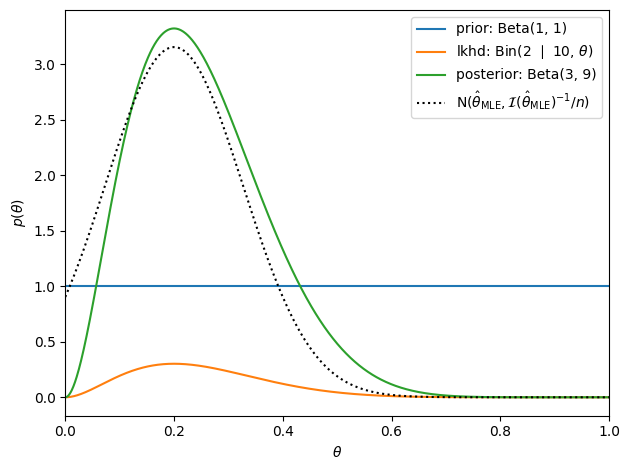

In [113]:
# Suppose we start with a uniform beta prior and observe 10 heads and 5 tails
alpha_prior = torch.as_tensor(1)
beta_prior = torch.as_tensor(1)
theta_true = 0.25
n = torch.as_tensor(10)
x = (theta_true * n).int()

# Plot the prior and the likelihood
plt.plot(thetas, Beta(alpha_prior, beta_prior).log_prob(thetas).exp(), label=f'prior: Beta({alpha_prior}, {beta_prior})')
plt.plot(thetas, Binomial(n, thetas).log_prob(x).exp(), label=fr'lkhd: Bin({x} $\mid$ {n}, $\theta$)')

# Compute and plot the posterior 
alpha_post = alpha_prior + x
beta_post = beta_prior + n - x
plt.plot(thetas, Beta(alpha_post, beta_post).log_prob(thetas).exp(), label=f'posterior: Beta({alpha_post}, {beta_post})')

# Compare to the sampling distribution of the MLE
theta_mle = x / n
var_mle = theta_mle * (1 - theta_mle) / n
plt.plot(thetas, Normal(theta_mle, torch.sqrt(var_mle)).log_prob(thetas).exp(), ':k', label=r'$\mathrm{N}(\hat{\theta}_{\mathsf{MLE}}, \mathcal{I}(\hat{\theta}_{\mathsf{MLE}})^{-1} / n)$', )

plt.xlim(0, 1)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend()
plt.tight_layout()


### Exponential Family Likelihoods

Consider a general **exponential family** likelihood with natural parameter $\theta$,
\begin{align*}
    p(x \mid \theta) &= h(x) \exp \left \{\langle t(x), \theta \rangle - A(\theta) \right \}.
\end{align*}

Exponential family distributions have conjugate priors,
\begin{align*}
    p(\theta; \chi, \nu) 
    &\propto \exp \left \{ \langle \chi, \theta \rangle - \nu A(\theta) \right \} \\
    &= \exp \left\{ \langle \chi, \theta \rangle + \langle \nu, -A(\theta) \rangle - B(\chi, \nu) \right\}.
\end{align*}
We recognize the conjugate prior as another exponential family distribution in which,
- the natural parameter $\chi$ are **pseudo-observations** of the sufficient statistics (like statistics from fake data points),
- the natural parameter $\nu$ is a **pseudo-count** (like the number of fake data points),
- the prior sufficient statistics are $(\theta, -A(\theta))$,
- the prior log normalizer is $B(\chi, \nu)$, and 

With a conjugate prior, the posterior distribution belongs to the same family as the prior,
\begin{align*}
p(\theta \mid \{x_i\}_{i=1}^n; \chi, \nu)
&\propto p(\theta; \chi, \nu) \prod_{i=1}^n p(x_i \mid \theta) \\
&\propto \exp \left\{ \chi + \sum_{i=1}^n t(x_i), \theta \rangle + \langle \nu + n, -A(\theta) \rangle \right\} \\
&= p(\theta \mid \chi', \nu')
\end{align*}
where
\begin{align*}
\chi' &= \chi + \sum_{i=1}^n t(x_i) \\
\nu' &= \nu + n.
\end{align*}
The posterior is a function of two quantities of fixed dimension, $\chi'$ and $\nu'$, regardless of how many data points are observed.

:::{admonition} Questions
1. Does each exponential family likelihood have a unique conjugate prior?
2. With a conjugate prior, the posterior is just a function of $\chi'$ and $\nu'$. Does that make it computationally tractable?
3. Do conjugate priors exist for likelihoods that are not exponential families?
:::


## Laplace Approximation

Conjugate priors are a common choice for simple exponential family models, but we need more general approaches for more complex models.

Suppose you wanted to perform Bayesian inference of the weights in a logistic regression model,
\begin{align*}
p(y \mid x, \mbbeta) 
&= \prod_{i=1}^n \mathrm{Bern}(y_i \mid \sigma(x_i^\top \mbbeta)).
\end{align*} 
Assume a Gaussian prior,
\begin{align*}
\mbbeta &\sim \mathrm{N}(\mbzero, \gamma^{-1} \mbI).
\end{align*}
Unfortunately, the posterior does not have a closed formation solution. Instead, a common form of approximate posterior inference is the **Laplace approximation**,
\begin{align*}
p(\mbbeta \mid x, y) &\approx \mathrm{N}(\hat{\mbbeta}_{\mathsf{MAP}}, \widehat{\mbSigma})
\end{align*}
where
\begin{align*}
\hat{\mbbeta}_{\mathsf{MAP}} 
&= \arg \max_{\mbbeta} \cL(\mbbeta)
\end{align*}
is the _maximum a posteriori (MAP)_ estimate, 
\begin{align*}
\widehat{\mbSigma}
&= -[\nabla^2 \cL(\hat{\mbbeta}_{\mathsf{MAP}})]^{-1} = \cI(\hat{\mbbeta}_{\mathsf{MAP}})^{-1}
\end{align*}
is an approximation of the posterior covariance, and
\begin{align*}
\cL(\mbbeta) 
&= \log p(\mbbeta) + \sum_{i=1}^n \log p(y_i \mid x_i, \mbbeta) \\
&= \log \mathrm{N}(\mbbeta; \mbzero, \gamma^{-1} \mbI) + \sum_{i=1}^n \log \mathrm{Bern}(y_i \mid \sigma(x_i^\top \mbbeta))
\end{align*}
is the log joint probability, _not the loss function from previous chapters!_

### Synthetic Demo

In [47]:
# Sample random covariates and data
torch.manual_seed(305 + ord('b'))
n = 50
X = Normal(0, 1).sample((n, 2))

# Fix true weights and variance
true_beta = torch.tensor([1.0, 1.0])
y = Bernoulli(logits=X @ true_beta).sample()

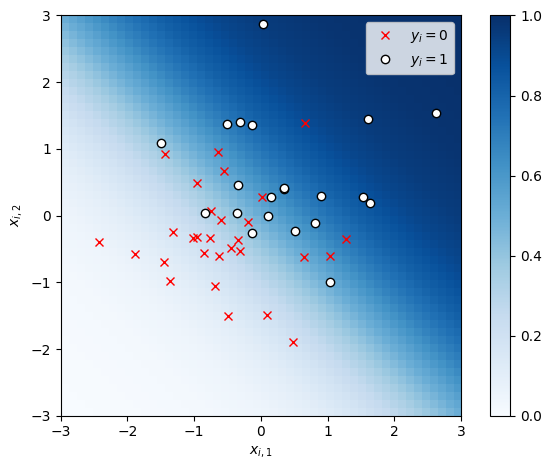

In [48]:
# Plot the data
x1s, x2s = torch.meshgrid(torch.linspace(-3, 3, 50), torch.linspace(-3, 3, 50))
x1x2 = torch.column_stack((x1s.ravel(), x2s.ravel()))
plt.imshow(torch.sigmoid(x1x2 @ true_beta).reshape(x1s.shape), 
           vmin=0, vmax=1, cmap="Blues", extent=(-3, 3, 3, -3))

plt.plot(X[y==0, 0], X[y==0, 1], 'rx', label=r"$y_i=0$")
plt.plot(X[y==1, 0], X[y==1, 1], 'wo', mec='k', mew=1, label=r"$y_i=1$")
plt.legend()
plt.xlabel(r"$x_{i,1}$")
plt.ylabel(r"$x_{i,2}$")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect("equal")
plt.colorbar()
plt.tight_layout()

# plt.savefig("data.pdf")
# files.download('data.pdf') 

Now plot the log joint probability as a function of the weights $w$.

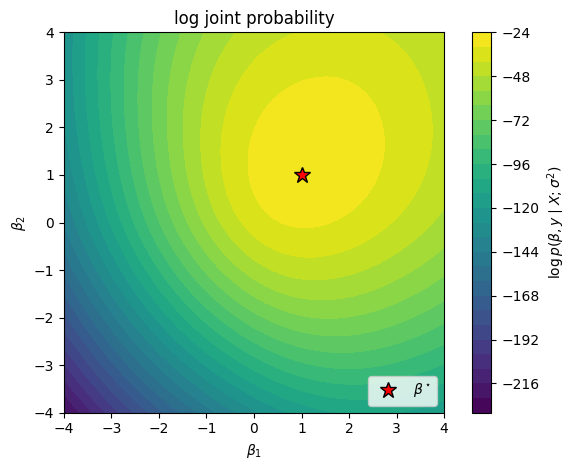

In [81]:
def log_joint(betas, sigmasq):
    # Add a batch dimension if necessary
    if betas.ndim == 1: betas = betas[None, :]

    # The log joint is the log likelihood plus the log prior
    lp = Bernoulli(logits=torch.einsum('np,mp->mn', X, betas)).log_prob(y).sum(axis=-1)
    lp += MultivariateNormal(torch.zeros(2), sigmasq * torch.eye(2)).log_prob(betas)
    return lp

# Plot the log joint
sigmasq = 1.0
beta1s, beta2s = torch.meshgrid(torch.linspace(-4, 4, 50), torch.linspace(-4, 4, 50))
beta12s = torch.column_stack((beta1s.ravel(), beta2s.ravel()))
# w_slice = torch.linspace(-4, 4)
lp = log_joint(beta12s, sigmasq).reshape(beta1s.shape)

plt.contourf(beta1s, beta2s, lp, 25)
plt.plot(true_beta[0], true_beta[1], 'r*', mec='k', ms=12, label=r"$\beta^\star$")
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.title("log joint probability")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal")
plt.legend(loc="lower right")
plt.colorbar(label=r"$\log p(\beta, y \mid X; \sigma^2)$")
plt.tight_layout()

Finally, compute the Laplace approximation. We'll use scikit learn to solve for the MAP estimate.

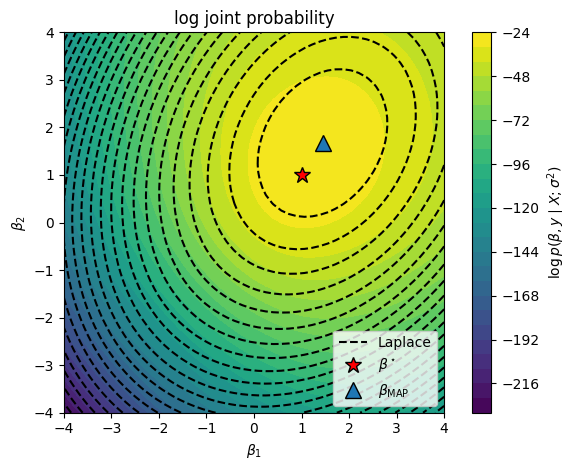

In [86]:
# Find the posterior mode with scikit learn
#   We have to be a bit careful with the regularization parameter because:
#       a) it is analogous to a precision, and 
#       b) it is weighted by the number of samples
#   To match the Bayesian prior, we need to set C = 1 / (sigma^2 / n)
lr = LogisticRegression(fit_intercept=False, penalty='l2', C=1 / (sigmasq / n))
beta_map = torch.as_tensor(lr.fit(X, y).coef_[0]).float()

# Compute the Laplace approximation
Sigma_laplace = -torch.linalg.inv(hessian(lambda beta: log_joint(beta, sigmasq), beta_map))
lp_laplace = MultivariateNormal(beta_map, Sigma_laplace).log_prob(beta12s).reshape(beta1s.shape)
plt.contourf(beta1s, beta2s, lp, 25)
plt.contour(beta1s, beta2s, lp_laplace, 25, colors='k')
plt.plot([], [], '--k', label="Laplace")

# Plot the log joint and the Laplace approximation to the posterior
plt.contourf(beta1s, beta2s, lp, 25)
plt.plot(true_beta[0], true_beta[1], 'r*', mec='k', ms=12, label=r"$\beta^\star$")
plt.plot(beta_map[0], beta_map[1], '^', mec='k', ms=12, label=r"$\beta_{\mathsf{MAP}}$")
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.title("log joint probability")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal")
plt.legend(loc="lower right")
plt.colorbar(label=r"$\log p(\beta, y \mid X; \sigma^2)$")
plt.tight_layout()

### Bernstein-von Mises Theorem

In the large data limit (as $n \to \infty$), the posterior is asymptotically normal, justifying the Laplace approximation in this regime.
    
Consider a simpler setting in which we have data $\{x_i\}_{i=1}^n \iid{\sim} p(x \mid \theta^\star)$.

Under some conditions (e.g. $\theta^\star$ not on the boundary of $\Theta$ and $\theta^\star$ has nonzero prior probability), then the MAP estimate is consistent. As $n \to \infty$,  $\theta_{\mathsf{MAP}} \to \theta^\star$.

Likewise,
\begin{align*} 
    p(\theta \mid \{x_i\}_{i=1}^n) \to \mathrm{N} \big(\theta \mid \theta^\star, \tfrac{1}{n} \cI(\theta^\star)^{-1} \big)
\end{align*}
where $\cI(\theta)$ is the Fisher information matrix.



<!-- 
### Approximating the model evidence

We can use the Laplace approximate to estimate the log marginal likelihood &mdash; a.k.a., the **model evidence**. Note that,
\begin{align*}
\log p(y \mid x) 
&= \log p(y, \mbbeta \mid x) - \log p(\mbbeta \mid x, y) \\
&\approx \cL(\mbbeta) - \log \mathrm{N}(\mbbeta \mid \mbbeta_{\mathsf{MAP}}, \hat{\mbSigma}).
\end{align*}
The first line is just Bayes' rule, and the right hand side holds for all $\mbbeta$. The second line is our Laplace approximation.
Evaluating at the MAP estimate,
\begin{align*}
\log p(y \mid x) 
&\approx \cL(\mbbeta_{\mathsf{MAP}}) - \log \mathrm{N}(\mbbeta_{\mathsf{MAP}} \mid \mbbeta_{\mathsf{MAP}}, \hat{\mbSigma}), \\
&\approx \cL(\mbbeta_{\mathsf{MAP}}) + \frac{D}{2} \log 2 \pi + \frac{1}{2} \log |\hat{\mbSigma}| 
\end{align*}
The marginal likelihood is a natural measure of model complexity, and it is often used for model selection (e.g., determining which features to include in the model). Here, we obtain a simple approximation that incorporates the log probability at the mode along with the "width" of the posterior. We'll revisit this approximation when we talk about model selection next week.  -->


## Conclusion

This was obviously a whirlwind of an introduction to Bayesian inference! There's plenty more to be said about Bayesian statistics &mdash; choosing a prior, subjective vs objective vs empirical Bayesian approaches, the role of the marginal likelihood in Bayesian model comparison, varieties of MCMC, and other approaches to approximate Bayesian inference. We'll dig into some of these topics as the course goes on, but for now, we have some valuable tools for developing Bayesian modeling and inference with discrete data!